# Regression MPE

Here we try to create regressions to predict Variaz on the basis of other features

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import folium
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [2]:
variaz = pd.read_csv('quake_data/variaz_phone_all.csv', sep=',')
variaz.head()

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz
0,Abbateggio,0.0,1633.760638,1760.015597,0.077279,-14.463097
1,Acciano,0.0,2560.456228,2732.586008,0.067226,-14.871586
2,Accumoli,1.0,6171.785673,2520.818603,-0.591558,-50.164385
3,Acquacanina,1.0,2203.589215,1719.542948,-0.219663,-34.796726
4,Acqualagna,0.0,20774.803092,22628.154837,0.089212,-9.514810


In [3]:
distance = pd.read_csv('quake_data/distance_from_epicenter2.csv', sep=',')
variaz = variaz.merge(distance)
variaz.head()

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz,Distance_from_epicenter
0,Abbateggio,0.0,1633.760638,1760.015597,0.077279,-14.463097,94.506502
1,Acciano,0.0,2560.456228,2732.586008,0.067226,-14.871586,78.792063
2,Accumoli,1.0,6171.785673,2520.818603,-0.591558,-50.164385,11.330255
3,Acquacanina,1.0,2203.589215,1719.542948,-0.219663,-34.796726,24.812085
4,Acqualagna,0.0,20774.803092,22628.154837,0.089212,-9.514810,104.085293


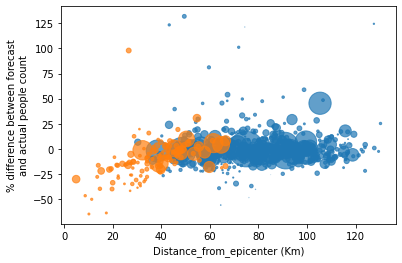

In [4]:
crat0 = variaz[variaz['Cratere Centro Italia 2016']==0]
crat1 = variaz[variaz['Cratere Centro Italia 2016']==1]
plt.scatter(crat0['Distance_from_epicenter'],crat0['Variaz'],s=crat0['media_dopo'] / 500,alpha=0.7)
plt.scatter(crat1['Distance_from_epicenter'],crat1['Variaz'],s=crat1['media_dopo'] / 500,alpha=0.7)
plt.xlabel('Distance_from_epicenter (Km)')
plt.ylabel('% difference between forecast\nand actual people count',multialignment='center')
plt.savefig('images/distance_desnt_explain.pdf',bbox_inches='tight')  
plt.show()

Distance from epicenter alone cannot explain Variaz

# Let's try analyzeing ATECO in the region

In [5]:
ateco2007 = pd.read_csv('quake_data/Ateco2007.csv', sep=';')
ateco1 = ateco2007[ateco2007['Codice Ateco 2007'].str.len()==1].reset_index().drop(['index','Codice Ateco 2007'],axis=1)
ateco1.columns = ['ateco1','desc1']
ateco2 = ateco2007[ateco2007['Codice Ateco 2007'].str.len()==2].reset_index().drop('index',axis=1)
ateco2.columns = ['ateco1','ateco2','desc2']
ateco = pd.merge(ateco1,ateco2)
ateco

,ateco1,desc1,ateco2,desc2
0,A,"AGRICOLTURA, SILVICOLTURA E PESCA",01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
1,A,"AGRICOLTURA, SILVICOLTURA E PESCA",02,SILVICOLTURA ED UTILIZZO DI AREE FORESTALI
2,A,"AGRICOLTURA, SILVICOLTURA E PESCA",03,PESCA E ACQUACOLTURA
3,B,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,05,ESTRAZIONE DI CARBONE (ESCLUSA TORBA)
4,B,ESTRAZIONE DI MINERALI DA CAVE E MINIERE,06,ESTRAZIONE DI PETROLIO GREGGIO E DI GAS NATURALE
...,...,...,...,...
83,S,ALTRE ATTIVITÀ DI SERVIZI,95,RIPARAZIONE DI COMPUTER E DI BENI PER USO PERS...
84,S,ALTRE ATTIVITÀ DI SERVIZI,96,ALTRE ATTIVITÀ DI SERVIZI PER LA PERSONA
85,T,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
86,T,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,98,PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI P...


In [6]:
# aida_crateri3.csv contiene proprio le aziende create prima del terremoto e che erano attive al momento del terremoto

aida = pd.read_csv('quake_data/aida_crateri3.csv')
aida = aida[['Comune','Ricavi delle vendite migl EUR Ultimo anno disp.','Dipendenti Ultimo anno disp.','Stato giuridico','ateco2']]
aida.columns = ['Comune','ricavi','dipendenti','stato','ateco2']

aida['ateco2'] = aida['ateco2'].astype('string')
m = aida['ateco2'].str.len().max()
aida['ateco2'] = aida['ateco2'].str.rjust(m, '0').astype('str').str[0:2]

aida[aida['ateco2']=='02']

,Comune,ricavi,dipendenti,stato,ateco2
115,Fabriano,2010.0,3,Attiva,02
183,Fabriano,601.0,0,Attiva,02
190,Fabriano,537.0,42,Fallita,02
249,Fabriano,250.0,30,Cessata (Fusione),02
434,Fabriano,1.0,2,Attiva,02
...,...,...,...,...,...
52484,Fara in Sabina,160.0,3,Attiva,02
52750,Caramanico Terme,136.0,1,Attiva,02
52911,Magliano de' Marsi,132.0,5,Attiva,02
53167,Massa d'Albe,0.0,0,Attiva,02


In [7]:
aida_ateco = pd.merge(aida.astype('str') , ateco.astype('str') , how='left', on='ateco2')
aida_ateco.loc[aida_ateco['ricavi'] == 'n.d.','ricavi'] = np.nan
aida_ateco.loc[aida_ateco['dipendenti'] == 'n.d.','dipendenti'] = np.nan
aida_ateco['ricavi'] = aida_ateco['ricavi'].astype('float')
aida_ateco['dipendenti'] = aida_ateco['dipendenti'].astype('float')
aida_ateco[aida_ateco['ateco1']=='A']
aida_ateco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53289 entries, 0 to 53288
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Comune      53289 non-null  object 
 1   ricavi      53289 non-null  float64
 2   dipendenti  53289 non-null  float64
 3   stato       53289 non-null  object 
 4   ateco2      53289 non-null  object 
 5   ateco1      53289 non-null  object 
 6   desc1       53289 non-null  object 
 7   desc2       53289 non-null  object 
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


In [8]:
aida_ateco.loc[aida_ateco['Comune']=='Acciano',:]

,Comune,ricavi,dipendenti,stato,ateco2,ateco1,desc1,desc2
52738,Acciano,120.0,2.0,Attiva,46,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,COMMERCIO ALL'INGROSSO (ESCLUSO QUELLO DI AUTO...
52739,Acciano,38.0,1.0,Attiva,81,N,"NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPO...",ATTIVITÀ DI SERVIZI PER EDIFICI E PAESAGGIO
52740,Acciano,8.0,0.0,Attiva,46,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,COMMERCIO ALL'INGROSSO (ESCLUSO QUELLO DI AUTO...


In [9]:

def ateco_groupby(df):
    aggregation = {'Comune':[np.size],'ricavi':[np.sum],'dipendenti':[np.sum]}
    ateco0 = df.groupby(['Comune']).aggregate(aggregation).reset_index()
    ateco0.columns = ['Comune','n_imprese','tot_ricavi','tot_dipendenti']
    ateco1 = df.groupby(['Comune', 'ateco1','desc1']).aggregate(aggregation).reset_index()
    ateco1.columns = ['Comune','ateco1','desc1','n_imprese','tot_ricavi','tot_dipendenti']
    ateco2 = df.groupby(['Comune','ateco2','desc2']).aggregate(aggregation).reset_index()
    ateco2.columns = ['Comune','ateco2','desc2','n_imprese','tot_ricavi','tot_dipendenti']
    return (ateco0,ateco1,ateco2)

imprese_ateco0,imprese_ateco1,imprese_ateco2 = ateco_groupby(aida_ateco)

imprese_ateco0.loc[imprese_ateco0['Comune']=='Acciano',:]

,Comune,n_imprese,tot_ricavi,tot_dipendenti
1,Acciano,3,166.0,3.0


In [10]:
imprese_ateco1.loc[imprese_ateco1['Comune']=='Acciano',:]

,Comune,ateco1,desc1,n_imprese,tot_ricavi,tot_dipendenti
2,Acciano,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,2,128.0,2.0
3,Acciano,N,"NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPO...",1,38.0,1.0


In [11]:
imprese_ateco2.loc[imprese_ateco2['Comune']=='Acciano',:]

,Comune,ateco2,desc2,n_imprese,tot_ricavi,tot_dipendenti
2,Acciano,46,COMMERCIO ALL'INGROSSO (ESCLUSO QUELLO DI AUTO...,2,128.0,2.0
3,Acciano,81,ATTIVITÀ DI SERVIZI PER EDIFICI E PAESAGGIO,1,38.0,1.0


In [12]:
# composizione dei comuni, voglio una cosa del tipo: il comune X è al 50% agrigolo...

denom = imprese_ateco0[['Comune','n_imprese','tot_ricavi']]
denom.columns = ['Comune','n_imprese0','tot_ricavi0']

imprese_ateco2 = imprese_ateco2.merge(denom)
imprese_ateco2['p_imprese'] = imprese_ateco2['n_imprese'] / imprese_ateco2['n_imprese0']
imprese_ateco2['p_ricavi'] = imprese_ateco2['tot_ricavi'] / imprese_ateco2['tot_ricavi0']

imprese_ateco1 = imprese_ateco1.merge(denom)
imprese_ateco1['p_imprese'] = imprese_ateco1['n_imprese'] / imprese_ateco1['n_imprese0']
imprese_ateco1['p_ricavi'] = imprese_ateco1['tot_ricavi'] / imprese_ateco1['tot_ricavi0']
imprese_ateco1.loc[imprese_ateco1['Comune']=='Acciano',:]

,Comune,ateco1,desc1,n_imprese,tot_ricavi,tot_dipendenti,n_imprese0,tot_ricavi0,p_imprese,p_ricavi
2,Acciano,G,COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZ...,2,128.0,2.0,3,166.0,0.666667,0.771084
3,Acciano,N,"NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPO...",1,38.0,1.0,3,166.0,0.333333,0.228916


In [19]:
value = 'p_ricavi'
imprese_ateco_wide = imprese_ateco1.pivot(index='Comune',columns='desc1')[value].fillna(0)
#imprese_ateco_wide = imprese_ateco2.pivot(index='Comune',columns='ateco2')[value].fillna(0)

ateco_names = ['AGRICOLTURE', 'OTHER','PUBLIC ADMINISTRATION','HOUSING',
       'ARTS AND ENTERTAINMENT','HOTELS AND RESTAURANTS',
       'FINANCE', 'MANUFACTURING','TECH PROFESSIONAL',
       'COMMERCE','BUILDINGS', 'MINING',
       'WATER AND WASTE','GAS AND ELECTRICITY',
       'EDUCATION','SERVICES AND OPERATIONS',
       'EXTRATERRITORIAL ORG.','HEALTH SERVICES',
       'COMMUNICATION AND INFORMATION SERV.','LOGISTICS']

imprese_ateco_wide.columns = ateco_names

imprese_ateco_wide.head(2)

,AGRICOLTURE,OTHER,PUBLIC ADMINISTRATION,HOUSING,ARTS AND ENTERTAINMENT,HOTELS AND RESTAURANTS,FINANCE,MANUFACTURING,TECH PROFESSIONAL,COMMERCE,BUILDINGS,MINING,WATER AND WASTE,GAS AND ELECTRICITY,EDUCATION,SERVICES AND OPERATIONS,EXTRATERRITORIAL ORG.,HEALTH SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
Comune,,,,,,,,,,,,,,,,,,,,
Abbateggio,0.0,0.0,0.0,0.0,0.0,0.24878,0.0,0.0,0.0,0.000000,0.75122,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Acciano,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.771084,0.00000,0.0,0.0,0.0,0.0,0.228916,0.0,0.0,0.0,0.0


In [33]:
xy = pd.merge(variaz, imprese_ateco_wide, how='inner', on='Comune').fillna(0)
xy = xy.loc[xy['Variaz']<50,:]
xy['Distance_from_epicenter']=(xy['Distance_from_epicenter']-xy['Distance_from_epicenter'].mean())/xy['Distance_from_epicenter'].std()

xy.columns = ['Comune', 'CRATER', 'PHONE_BEFORE', 'PHONE_AFTER',
              'PCGH', 'MPE', 'DISTANCE FROM EPICENTER']+ateco_names

xy.head()

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,DISTANCE FROM EPICENTER,AGRICOLTURE,OTHER,PUBLIC ADMINISTRATION,...,BUILDINGS,MINING,WATER AND WASTE,GAS AND ELECTRICITY,EDUCATION,SERVICES AND OPERATIONS,EXTRATERRITORIAL ORG.,HEALTH SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
0,Abbateggio,0.0,1633.760638,1760.015597,0.077279,-14.463097,0.938927,0.000000,0.0,0.0,...,0.751220,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
1,Acciano,0.0,2560.456228,2732.586008,0.067226,-14.871586,0.328794,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.228916,0.0,0.000000,0.00000,0.000000
2,Accumoli,1.0,6171.785673,2520.818603,-0.591558,-50.164385,-2.290493,0.301518,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.174078
3,Acqualagna,0.0,20774.803092,22628.154837,0.089212,-9.514810,1.310835,0.029193,0.0,0.0,...,0.008529,0.006331,0.000000,0.0,0.000000,0.071312,0.0,0.163113,0.00000,0.000000
4,Acquapendente,0.0,32899.568839,37150.089286,0.129197,0.907305,1.377622,0.001679,0.0,0.0,...,0.031022,0.000000,0.004422,0.0,0.002677,0.009277,0.0,0.003292,0.00793,0.000000


In [34]:
xy_crat = pd.merge(variaz, imprese_ateco_wide, how='inner', on='Comune').fillna(0)
xy_crat = xy_crat[xy_crat['Cratere Centro Italia 2016']==1]
#xy_crat = xy_crat.loc[xy_crat['Variaz']<50,:]
xy_crat['Distance_from_epicenter']=(xy_crat['Distance_from_epicenter']-xy_crat['Distance_from_epicenter'].mean())/xy_crat['Distance_from_epicenter'].std()


xy_crat.columns = ['Comune', 'CRATER', 'PHONE_BEFORE', 'PHONE_AFTER',
              'PCGH', 'MPE', 'DISTANCE FROM EPICENTER']+ateco_names

xy.to_csv('quake_data/X_regression.csv',index=False)
xy_crat.head()


,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,DISTANCE FROM EPICENTER,AGRICOLTURE,OTHER,PUBLIC ADMINISTRATION,...,BUILDINGS,MINING,WATER AND WASTE,GAS AND ELECTRICITY,EDUCATION,SERVICES AND OPERATIONS,EXTRATERRITORIAL ORG.,HEALTH SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
2,Accumoli,1.0,6171.785673,2520.818603,-0.591558,-50.164385,-2.072743,0.301518,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.174078
5,Acquasanta Terme,1.0,15586.085229,15172.258024,-0.026551,-20.579991,-1.504793,0.000000,0.0,0.0,...,0.131887,0.069939,0.0,0.0,0.000000,0.003501,0.0,0.001065,0.000000,0.035921
14,Amandola,1.0,23203.310837,24829.737794,0.070095,-16.145167,-0.898951,0.006760,0.0,0.0,...,0.024106,0.000000,0.0,0.0,0.000579,0.051688,0.0,0.000000,0.042069,0.000000
15,Amatrice,1.0,17202.975125,10522.783228,-0.388316,-33.685087,-1.395044,0.019120,0.0,0.0,...,0.228585,0.000000,0.0,0.0,0.000000,0.002177,0.0,0.000000,0.000000,0.000000
19,Antrodoco,1.0,9796.916249,10260.919078,0.047362,2.915668,0.437330,0.000000,0.0,0.0,...,0.488605,0.000000,0.0,0.0,0.000000,0.027920,0.0,0.002386,0.000000,0.000000


In [35]:
def add_regioni(df):
    cod_reg_nome = pd.DataFrame({'COD_REG':[10,11,12,13],'Regione':['UMBRIA','MARCHE','LAZIO','ABRUZZO']})
    comune_regione = pd.read_csv('terremoto/comune_regione.csv').merge(cod_reg_nome)[['Comune','Regione']]
    df = df.merge(comune_regione)
    regioni = pd.get_dummies(df['Regione']) #one hot encoding
    df = pd.concat([df,regioni],axis='columns').drop(['Regione'],axis='columns')
    return df

xy = add_regioni(xy)
xy_crat = add_regioni(xy_crat)

C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


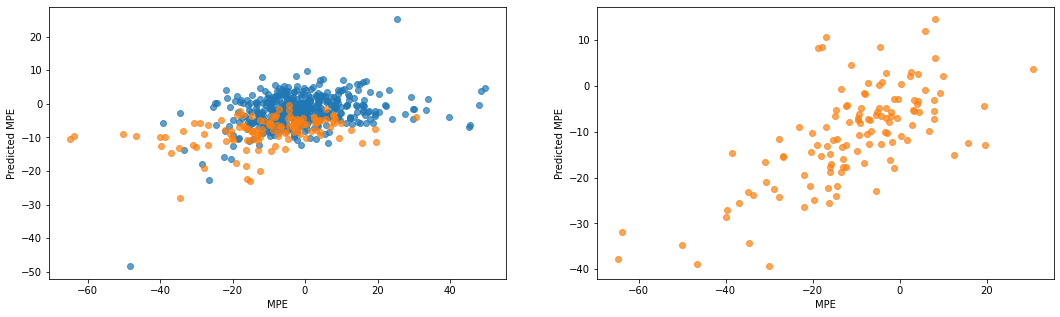

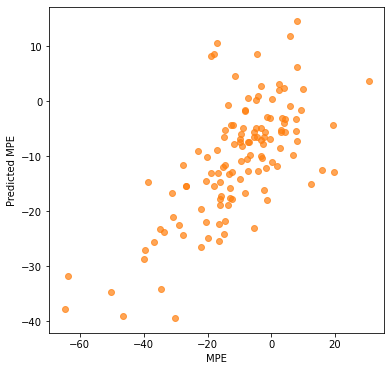

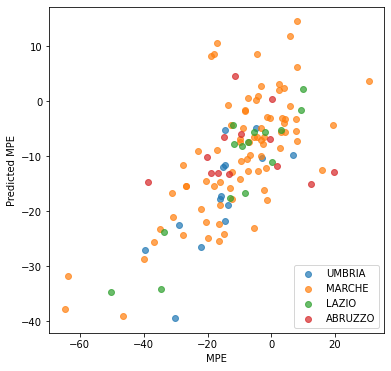

In [40]:

feat = ateco_names + ['DISTANCE FROM EPICENTER']# + ['UMBRIA','MARCHE','LAZIO','ABRUZZO']

x = xy[feat]
y = xy['MPE'] 

xy_crat = xy_crat.loc[xy_crat['Comune']!='Sellano',:]
x_crat = xy_crat[feat]
y_crat = xy_crat['MPE'] 

x_crat = x_crat - x_crat.mean() / x_crat.std()
x_crat = x_crat.dropna(axis='columns')

x = sm.add_constant(x)
x_crat = sm.add_constant(x_crat)

model = sm.OLS(y, x).fit()
model_crat = sm.OLS(y_crat, x_crat).fit()

yp = model.predict(x)
yp_crat = model_crat.predict(x_crat)

plt.figure(figsize = (18, 5))
plt.subplot(1,2,1)
plt.scatter(y[xy.loc[xy['CRATER']==0,:].index],yp[xy.loc[xy['CRATER']==0,:].index],alpha=0.7)
plt.scatter(y[xy.loc[xy['CRATER']==1,:].index],yp[xy.loc[xy['CRATER']==1,:].index],alpha=0.7)
plt.xlabel(y.name)
plt.ylabel('Predicted '+y.name)
plt.subplot(1,2,2)
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],alpha=0.7)
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],alpha=0.7)
plt.xlabel(y.name)
plt.ylabel('Predicted '+y.name)
plt.show()

plt.figure(figsize = (6,6))
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],alpha=0.7)
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],alpha=0.7)
plt.xlabel('MPE')
plt.ylabel('Predicted MPE')
plt.savefig('images/model1.pdf',bbox_inches='tight')  
plt.show()

plt.figure(figsize = (6,6))
for r in ['UMBRIA','MARCHE','LAZIO','ABRUZZO']:
    plt.scatter(y_crat[xy_crat.loc[xy_crat[r]==1,:].index],yp_crat[xy_crat.loc[xy_crat[r]==1,:].index],alpha=0.7, label=r)
plt.xlabel('MPE')
plt.ylabel('Predicted MPE')
plt.legend(loc='lower right')
plt.savefig('images/model1_region.pdf',bbox_inches='tight')  
plt.show()



stargazer = Stargazer([model_crat])
with open('models/model_pre.tex','w') as f:
        f.write(stargazer.render_latex())
stargazer.render_latex()
stargazer